In [1]:
import torch
import matplotlib.pyplot as plt
import math

from renderer import project_gaussians, rasterize_gaussians, get_bounding_boxes, tile_gaussians, g
from utils import ellipse_ndim, plot_tile_map

from matplotlib.patches import Polygon
from tqdm import tqdm

### Data

In [2]:
N = 10

mu = (torch.rand((N,3)) - 0.5) * 4.
scale = torch.rand((N,3)) * 0.2
quat = torch.rand((N, 4))
col = torch.rand((N, 3))
opc = torch.rand((N,))

In [3]:
mu.requires_grad = True
scale.requires_grad = True
quat.requires_grad = True
col.requires_grad = True
opc.requires_grad = True

### Projection

In [4]:
# Output Image Width and Height
W = 1800
H = 1000 

In [5]:
fov_x = math.pi / 2.0 # Angle of the camera frustum 90°
focal = 0.5 * float(W) / math.tan(0.5 * fov_x) # Distance to Image Plane

viewmat = torch.eye(4)
viewmat[:3,3] = torch.tensor([0,0,-4])

In [6]:
(
    mu_,
    cov_,
    z
) = project_gaussians(
    means3d=mu,
    scales=scale,
    quats=quat,
    colors=col,
    viewmat=viewmat,
    fx=focal,
    fy=focal,
    cx=W/2,
    cy=H/2,
    img_height=H,
    img_width=W
)

### Rendering

In [7]:
out_img = rasterize_gaussians(
    xys=mu_,
    depths=z,
    covs=cov_,
    conics=None,
    num_tiles_hit=None,
    colors=col,
    opacity=opc,
    img_height=H,
    img_width=W,
    block_width=None,
    background=None,
    return_alpha=None
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


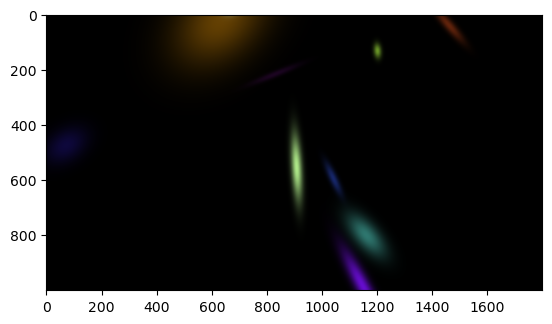

In [8]:
plt.imshow(out_img.detach())

In [9]:
loss = out_img.mean()

In [10]:
loss.backward()

In [11]:
mu.grad

tensor([[-6.2729e-04,  1.8687e-04,  7.1966e-04],
        [-1.3078e-04,  8.2809e-04,  4.2677e-05],
        [-2.6039e-03,  7.7635e-03,  1.5689e-03],
        [ 2.2168e-04,  1.2047e-04,  2.3174e-04],
        [-1.6025e-03,  1.1881e-03,  4.8144e-03],
        [ 4.0217e-04, -2.6762e-03,  8.3665e-05],
        [-2.3464e-04,  7.4928e-04,  2.1431e-03],
        [ 2.2651e-04,  1.5482e-04,  9.4532e-05],
        [ 2.6796e-05,  1.4620e-03, -7.2345e-04],
        [ 1.1790e-04, -4.4195e-04,  2.9556e-04]])

### Tiling

In [ ]:
rot_box = get_bounding_boxes(mu_, cov_)

In [ ]:
tile_size = 200

In [ ]:
tile_map = tile_gaussians(mu_, cov_, tile_size, H, W)

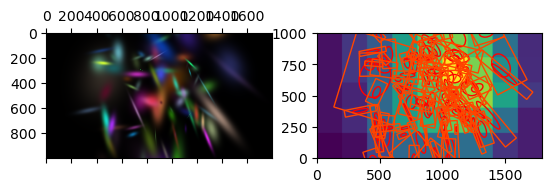

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

plot_tile_map(tile_map, H, W, ax=ax2)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

for box in rot_box:
    ax2.add_patch(Polygon(box, fc='none', ec='orangered'))

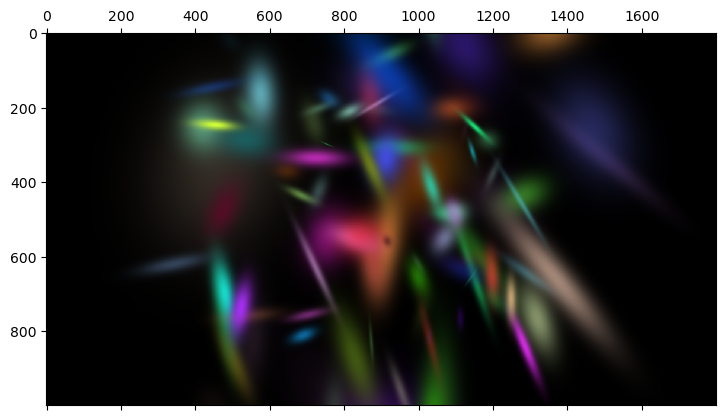

In [ ]:
plt.matshow(out_img)

In [ ]:
def rasterize_gaussians_patch(
        xys,
        covs,
        colors,
        opacity,
        x_range, 
        y_range,
    ):
    x_min, x_max = x_range
    y_min, y_max = y_range

    w = x_max - x_min
    h = y_max - y_min

    x, y = torch.meshgrid(torch.linspace(x_min, x_max, w),torch.linspace(y_min, y_max, h), indexing='xy')
    x = x.reshape(1,-1); y = y.reshape(1, -1)

    # _, ind = torch.sort(depths)
    # xys, covs, colors = xys[ind], covs[ind], colors[ind]

    pixels_xy = torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0)

    out_img = torch.zeros(h, w, 3)
    cum_alphas = torch.ones(1, h, w)
    for m, S, c, o in zip(xys, covs, colors, opacity):
        alpha = g(pixels_xy, m, S).view(1, h, w) * o
        out_img += (alpha * c.view(3,1,1) * cum_alphas).permute((1,2,0)).flip(dims=(0,))
        cum_alphas *= (1 - alpha)

    return out_img

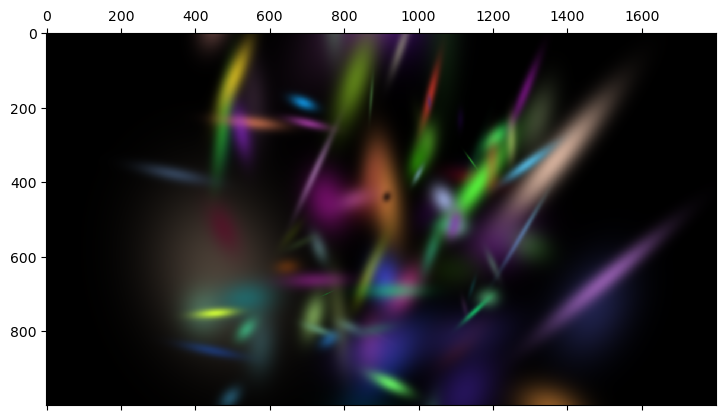

In [ ]:
plt.matshow(rasterize_gaussians_patch(mu_, cov_, col, opc, 
                          (0, W), (0, H)).flip(dims=(0,)))

In [ ]:
def rasterize_tile(
        xys,
        covs,
        colors,
        opacity,
        x_coord, 
        y_coord,
        tile_size,
        out_img
    ):
    x_min, x_max = x_coord*tile_size, (x_coord+1)*tile_size
    y_min, y_max = y_coord*tile_size, (y_coord+1)*tile_size

    # print(x_min, x_max, y_min, y_max)
    
    # x, y = torch.meshgrid(torch.linspace(x_min, x_max, tile_size),torch.linspace(y_min, y_max, tile_size), indexing='xy')
    x, y = torch.meshgrid(torch.arange(x_min, x_max), torch.arange(y_min, y_max))
    x = x.reshape(1,-1); y = y.reshape(1, -1)

    pixels_xy = torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0)

    # out_img = torch.zeros(tile_size, tile_size, 3)
    cum_alphas = torch.ones(1, tile_size, tile_size)
    for m, S, c, o in zip(xys, covs, colors, opacity):
        alpha = g(pixels_xy, m, S).view(1, tile_size, tile_size) * o
        out_img[y_min:y_max, x_min:x_max] += (alpha * c.view(3,1,1) * cum_alphas).permute((2,1,0))#.flip(dims=(0,))
        cum_alphas *= (1 - alpha)

    return out_img

In [ ]:
out_img = torch.zeros(H, W, 3)
for y in tqdm(range(len(tile_map))):
    for x in range(len(tile_map[0])):
        # if tile_map[y][x]:
        rasterize_tile(
            xys=mu_, covs=cov_, colors=col, opacity=opc,
            x_coord=x, y_coord=y, tile_size=tile_size,
            out_img=out_img
        )

  0%|          | 0/5 [00:00<?, ?it/s]

/home/yasin/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 5/5 [00:27<00:00,  5.54s/it]


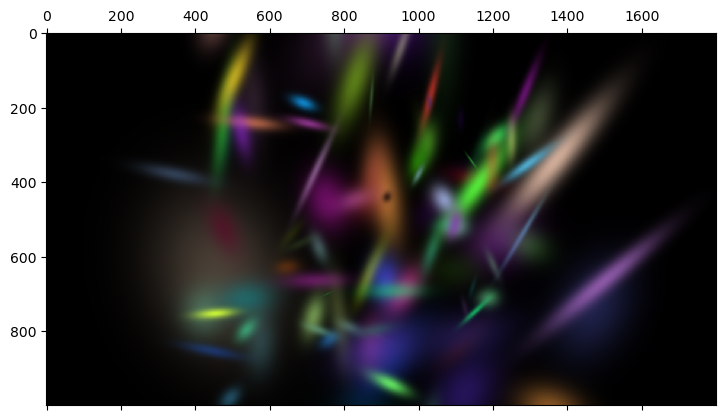

In [ ]:
plt.matshow(out_img)